In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns; sns.set()

In [9]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

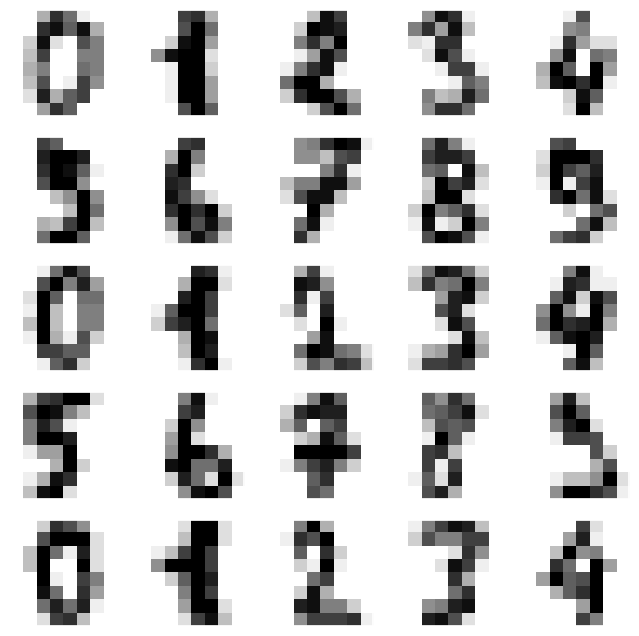

In [3]:
def plot_digits(data, rows=5, col=5, fsize=(8,8)):
    fig, ax = plt.subplots(rows,col, figsize=fsize)

    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        axi.set_xticks([])
        axi.set_yticks([])
        im.set_clim(0, 16)

plot_digits(digits.data)

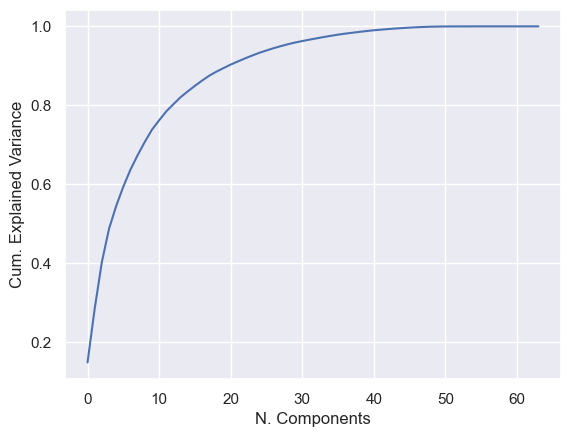

In [4]:
from sklearn.decomposition import PCA

pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('N. Components')
plt.ylabel('Cum. Explained Variance');

In [5]:
pca = PCA(0.99, whiten=True)
pca_data = pca.fit_transform(digits.data)

pca_data.shape

(1797, 41)

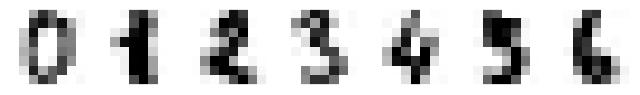

In [6]:
plot_digits(pca.inverse_transform(pca_data), 1, 7)

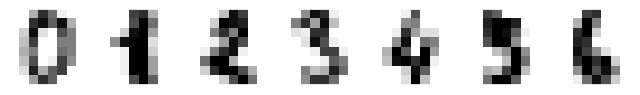

In [7]:
plot_digits(digits.data, 1, 7)

## KMeans

In [8]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10, random_state=0)
clusters = k_means.fit_predict(pca_data)

c:\Users\matte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


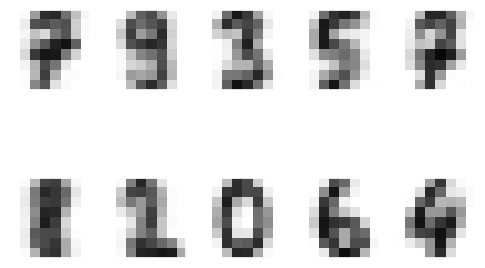

In [11]:
plot_digits(pca.inverse_transform(k_means.cluster_centers_), rows=2, col=5, fsize=(6,4))

In [31]:
center_coords = k_means.predict(k_means.cluster_centers_)
center_coords

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [47]:
labels = np.zeros_like(clusters)

labels[clusters==0] = 7
labels[clusters==1] = 9
labels[clusters==2] = 3
labels[clusters==3] = 5
labels[clusters==4] = 7
labels[clusters==5] = 8
labels[clusters==6] = 2
labels[clusters==7] = 0
labels[clusters==8] = 6
labels[clusters==9] = 4

In [26]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7362270450751253

## Spectral Clustering

In [33]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=10,
                           affinity='nearest_neighbors',
                           assign_labels='discretize',
                           n_jobs=-1)

sp_clusters = model.fit_predict(pca_data)

0.805230940456316

In [35]:
sp_cluster_centers = np.array([pca_data[sp_clusters==i].mean(axis=0) for i in range(10)])

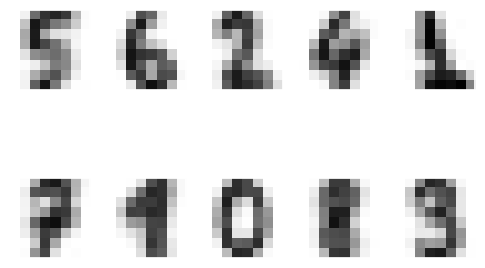

In [36]:
plot_digits(pca.inverse_transform(sp_cluster_centers), rows=2, col=5, fsize=(6,4))

In [40]:
sp_labels = np.zeros_like(clusters)

sp_labels[sp_clusters==0] = 5
sp_labels[sp_clusters==1] = 6
sp_labels[sp_clusters==2] = 2
sp_labels[sp_clusters==3] = 4
sp_labels[sp_clusters==4] = 1
sp_labels[sp_clusters==5] = 7
sp_labels[sp_clusters==6] = 1
sp_labels[sp_clusters==7] = 0
sp_labels[sp_clusters==8] = 8
sp_labels[sp_clusters==9] = 3

In [41]:
accuracy_score(digits.target, sp_labels)

0.805230940456316

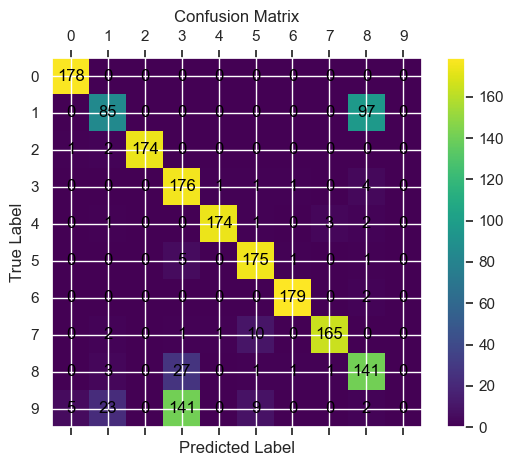

In [42]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, sp_labels)

def plot_confusion_matrix(matrix):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='viridis')
    plt.xticks(np.arange(len(digits.target_names)), digits.target_names)
    plt.yticks(np.arange(len(digits.target_names)), digits.target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.colorbar(cax)

    for i in range(len(digits.target_names)):
        for j in range(len(digits.target_names)):
            plt.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

    plt.show()

plot_confusion_matrix(mat)

## t-SNE

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=1, n_jobs=-1)
ts_data = tsne.fit_transform(pca_data)

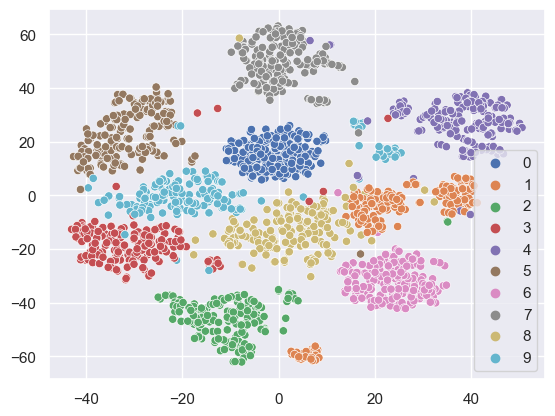

In [50]:
sns.scatterplot(x=ts_data[:,0], y=ts_data[:,1], hue=digits.target, palette="deep");

In [65]:
kmeans = KMeans(n_clusters=10, random_state=1)
ts_kmeans_predictions = kmeans.fit_predict(ts_data)

ts_kmeans_labels = np.zeros_like(ts_kmeans_predictions)
for i in range(10):
    mask = (ts_kmeans_predictions == i)
    ts_kmeans_labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, ts_kmeans_labels)

0.9348914858096828

In [66]:
np.unique(ts_kmeans_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

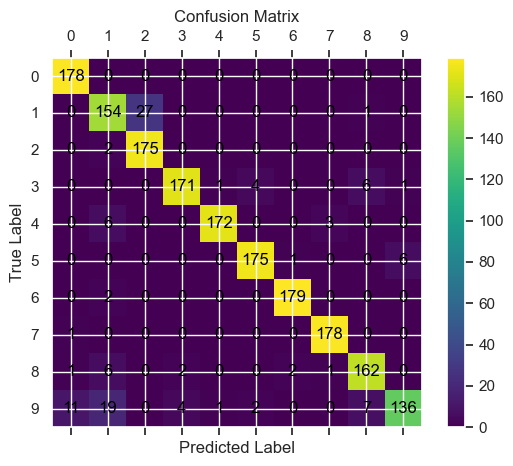

In [67]:
ts_kmeans_mat = confusion_matrix(digits.target, ts_kmeans_labels)

plot_confusion_matrix(ts_kmeans_mat)

In [221]:
specral_c = SpectralClustering(n_clusters=10,
                           affinity='nearest_neighbors',
                           assign_labels='discretize',
                           n_jobs=-1)

ts_spectral_pred = specral_c.fit_predict(ts_data)

ts_spectral_labels = np.zeros_like(ts_spectral_pred)
for i in range(10):
    mask = (ts_spectral_pred == i)
    ts_spectral_labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, ts_spectral_labels)

0.7045075125208681

In [229]:
np.unique(ts_spectral_labels)

array([0, 1, 2, 3, 5, 6, 7, 9], dtype=int64)

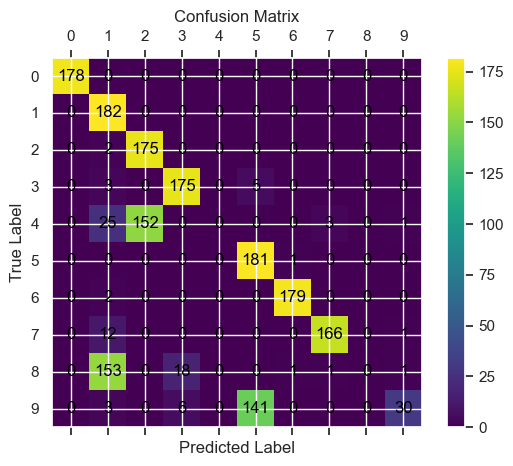

In [230]:
ts_spectral_mat = confusion_matrix(digits.target, ts_spectral_labels)

plot_confusion_matrix(ts_spectral_mat)

## Drawing numbers from input

In [68]:
from sklearn.mixture import GaussianMixture as GMM

gmm_models = {}

for num in np.unique(ts_kmeans_labels):
    mask = (ts_kmeans_labels == num)
    gmm_models[num] = GMM(n_components=15, covariance_type='full').fit(pca_data[mask])


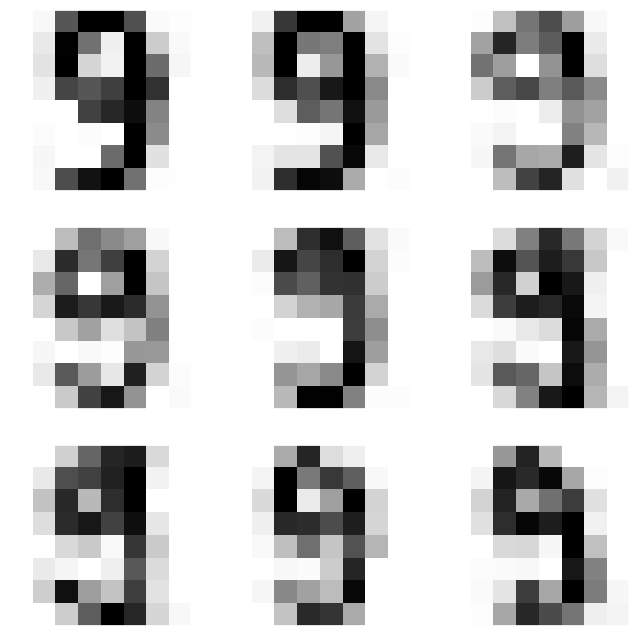

In [69]:
new_data, _ = gmm_models[9].sample(9)
new_data = pca.inverse_transform(new_data)
plot_digits(new_data, 3, 3)

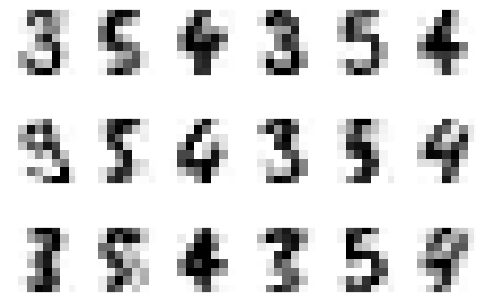

In [76]:
def plot_input_digits(input_n):
    list_num = list(input_n)

    try:
        list_num = list(map(int, list_num))
    except ValueError:
        print('Please, select just 3 numbers.')
        return None

    results = np.zeros(shape=(18, 64))

    if len(list_num) != 3:
        print('Please, select just 3 numbers.')

    else:
        for i, num in enumerate(list_num*6):
            sample, _ = gmm_models[num].sample(1)
            results[i] = pca.inverse_transform(sample)

        plot_digits(results, 3, 6, (6,4))

plot_input_digits('354')

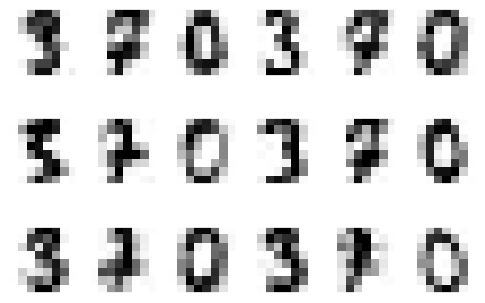

In [79]:
plot_input_digits('370')